# Amplitude Source Location (ASL) - Recreating Jacob's notebook with flovopy

## 1. Imports

[INV] Networks: 1  Stations: 5  Channels: 18
Dome (assumed source) = {'lat': 14.475, 'lon': -90.88}
[GRID] 361x361 nodes (130321 total)  spacing=50.0 m  [no mask]


/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Grid


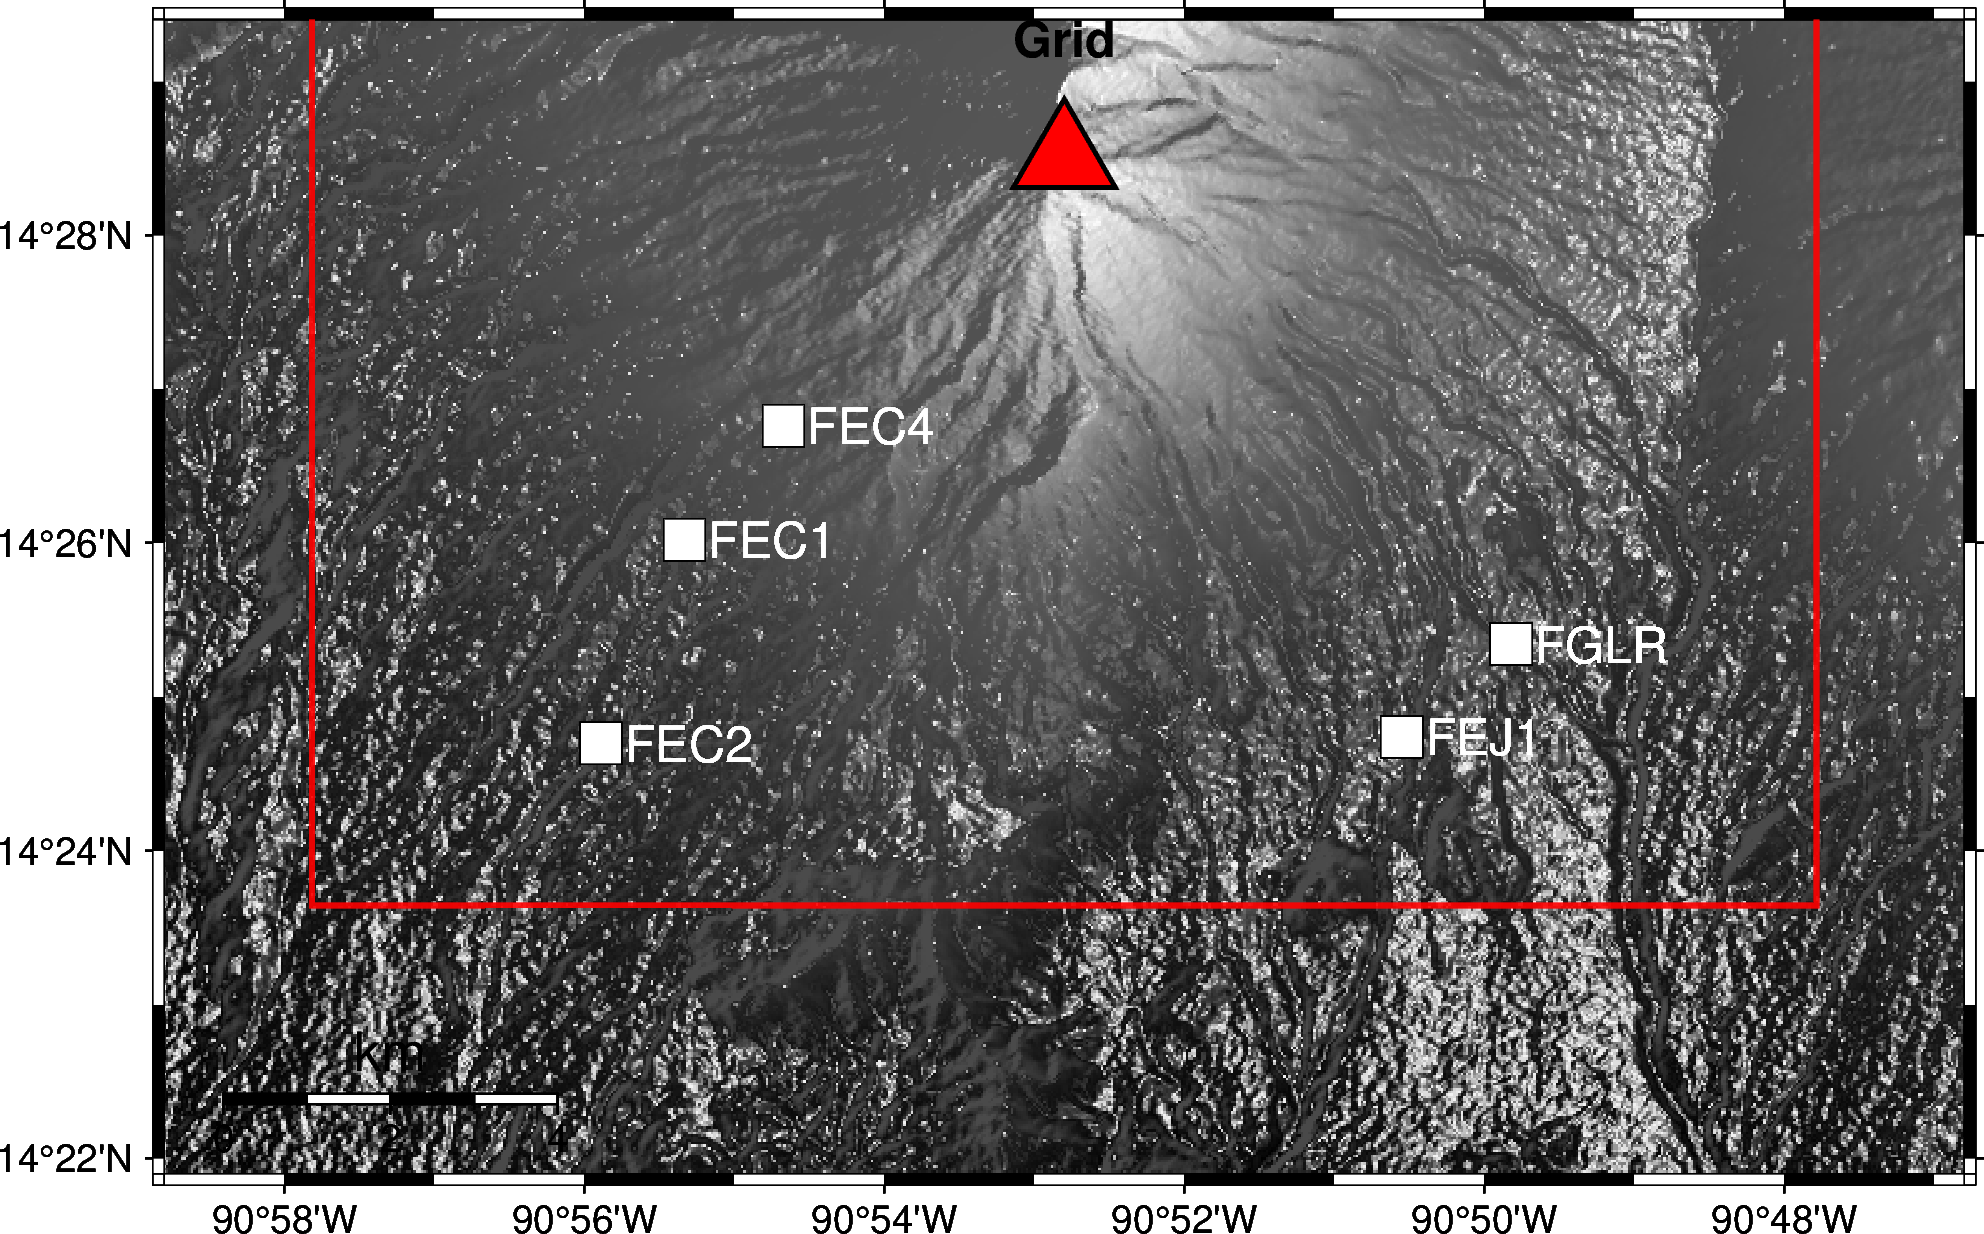

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read_inventory, UTCDateTime
from importlib import reload
from flovopy.asl.wrappers import run_single_event, find_event_files, run_all_events
from flovopy.processing.sam import VSAM, DSAM 
from flovopy.asl.config import ASLConfig, tweak_config

# Core ASL + utilities
from flovopy.asl.asl import ASL
from flovopy.asl.wrappers import asl_sausage
from flovopy.asl.grid import Grid, make_grid
from flovopy.asl.distances import compute_or_load_distances, distances_signature
from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams
from flovopy.asl.misfit import StdOverMeanMisfit, R2DistanceMisfit, LinearizedDecayMisfit
from flovopy.asl.map import topo_map

# --- Diagnostics / comparisons ---
from flovopy.asl.compare import extract_asl_diagnostics, compare_asl_sources

# --- Simulation helpers ---
from flovopy.asl.simulate import simulate_SAM, plot_SAM, synthetic_source_from_grid

# -------------------------- Config --------------------------
# directories
HOME = Path.home()
DATA_DIR = HOME / 'Dropbox' / 'BRIEFCASE'/ 'SSADenver'  /'Jacob'

# master files
INVENTORY_XML   = DATA_DIR / "6Q.xml"

REGION_DEFAULT = [-90.98, -90.78, 14.365, 14.49]
DEM_DEFAULT = None

# other parameters
DIST_MODE = "2d"

# Inventory of Montserrat stations
INV     = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

MAT_FILE = DATA_DIR / "outputfromReadMapData.mat"
MSEED_DIR = DATA_DIR / "ClipMSEED"                # directory containing MiniSEED


'''
SRTM_ASC_GZ = DATA_DIR / "srtm_18_10.asc.gz"      # optional background
SRTM_CELL = 0.00083333333333333
SRTM_XLL  = -95.0
SRTM_YLL  = 10.0

stations = ['FEJ1', 'FEC1', 'FEC2', 'FEC4']       # order must match sta rows

# Seismo params
sps = 200
lc, hc = 1.0, 99.0                                # bandpass (Hz)
pre_filt = (0.5, 0.8, 90.0, 100.0)                # for remove_response
beta = 1250.0                                     # m/s, assumed wave speed
m_slope = -1.0                                    # -1 body, -0.5 surface

winlength_seconds = 10
plot_limits_sec = (7500, 10000)
t_start_sec = 8000
t_end_sec   = 9200

# Local-grid -> UTM offsets (apply BEFORE transforming to geographic)
UTM_E_OFFSET = 715_901.84
UTM_N_OFFSET = 1_584_182.68

# CRS (example: UTM zone 15N; change if needed)
CRS_UTM = CRS.from_epsg(32615)
CRS_WGS84 = CRS.from_epsg(4326)
TO_WGS84 = Transformer.from_crs(CRS_UTM, CRS_WGS84, always_xy=True)

'''

# Montserrat constants
dome_location = {'lat': 14.475, 'lon':-90.88}
print("Dome (assumed source) =", dome_location)

# define grid size and spacing
GRID_SIZE_LAT_M = 18_000   
GRID_SIZE_LON_M = 18_000  
NODE_SPACING_M  = 50       


gridobj = make_grid(
    center_lat=dome_location["lat"],
    center_lon=dome_location["lon"],
    node_spacing_m=NODE_SPACING_M,
    grid_size_lat_m=GRID_SIZE_LAT_M,
    grid_size_lon_m=GRID_SIZE_LON_M,
    dem=None,
)
print(gridobj)

# Parameters to pass for making pygmt topo maps
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
    "topo_color": False,
}

gridobj.plot(show=True, min_display_spacing=300, scale=2.0, topo_map_kwargs=topo_kw);



## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

In [ ]:
startt = UTCDateTime(2003,7,12,23,0,0)
endt = UTCDateTime(2003,7,13,4,0,0)
invMVO = INV.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
topo_map(inv=invMVO, show=True, add_labels=True, dem_tif=DEM_DEFAULT);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

In [ ]:
# params
sampling_interval = 1.0  # seconds, to simulate moving window

# grid params
node_spacing_m = 400
nlat = 8   # 11
nlon = 8   # 11
centerlat =  16.711
centerlon =  -62.177

synthgridobj = Grid(centerlat, centerlon, nlat, nlon, node_spacing_m)
topo_kw = {'inv':invMVO, 'dem_tif':DEM_DEFAULT, 'add_labels':True, 'region':REGION_DEFAULT}
synthgridobj.plot(scale=2, symbol='c', topo_map_kwargs=topo_kw)

synthetic_source = synthetic_source_from_grid(
    synthgridobj,
    sampling_interval=sampling_interval,
    DR_cm2=100.0,
    t0=UTCDateTime(),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

synthVSAMobj = simulate_SAM(
    invMVO,
    synthetic_source,
    units='m/s',
    assume_surface_waves=True,
    wave_speed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
    verbose=True,
)
synthVSAMobj.plot(metrics="mean")

In [ ]:
print(synthVSAMobj.get_seed_ids()  )
plot_SAM(synthVSAMobj, synthgridobj, K=3, metric='mean', topo_kw=topo_kw)

### 2.3 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

In [ ]:
window_seconds = 1
'''
    # Required
    inventory: Inventory | str | Path
    output_base: str | Path
    gridobj: Grid
    global_cache: str | Path

    # Physical/config knobs
    wave_kind: str = "surface"  # "surface" | "body"
    station_correction_dataframe: pd.DataFrame | str | Path | None = None
    speed: float = 1.5  # km/s
    Q: int = 100
    dist_mode: str = "3d"       # "2d" | "3d"
    misfit_engine: str = "l2"
    peakf: float = 8.0          # Hz
    window_seconds: float = 5.0
    min_stations: int = 5
    sam_class: type = VSAM       # class, not instance
    sam_metric: str = "mean"
    debug: bool = False
'''

cfg = ASLConfig(
    inventory=invMVO, 
    output_base=OUTPUT_DIR, 
    gridobj=synthgridobj,
    wave_kind='surface',
    speed=surfaceWaveSpeed_kms,
    peakf = peakf,
    Q = Q,
    window_seconds=window_seconds,
    global_cache='/tmp'
).build()
aslobj = ASL(synthVSAMobj, cfg)
aslobj.source = synthetic_source
aslobj.plot(threshold_DR=1.0, scale=0.4, topo_kw=topo_kw);

### 2.4 Run slow location algorithm on synthetic source and plot resulting locations and DR time series

In [ ]:
#  Locate & time
t0 = UTCDateTime()
aslobj.locate(verbose=True)
t1 = UTCDateTime()
print(f"[TIMER] Location algorithm took {t1 - t0:.3f} s")

# Plot
aslobj.plot(topo_kw=topo_kw, scale=0.4, threshold_DR=0.0);

### 2.5 Run fast location algorithm on synthetic source and plot resulting locations and DR time series

In [ ]:
import copy
aslobj2 = copy.deepcopy(aslobj)
aslobj2.source = None
time1 = UTCDateTime()
aslobj2.fast_locate(misfit_backend=StdOverMeanMisfit())
time2 = UTCDateTime()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj2.plot(topo_kw=topo_kw, scale=0.4, threshold_DR=0.0);

# Compare results. Any differences?
from flovopy.asl.compare import compare_asl_sources, plot_asl_source_comparison

# stats
report = compare_asl_sources(aslobj, aslobj2)
print(report)  # mean/max km divergence, DR deltas, etc.

# visuals
plot_asl_source_comparison(aslobj, aslobj2, title="locate vs fast locate (StdOverMean)")

In [ ]:
from flovopy.asl.misfit import LinearizedDecayMisfit
aslobj3 = copy.deepcopy(aslobj)
aslobj3.source = None
time1 = UTCDateTime()
# pure correlation (most aggressive)
#aslobj3.fast_locate(misfit_backend=R2DistanceMisfit(use_log=True, square=True, alpha=1.0))
aslobj3.fast_locate(misfit_backend=LinearizedDecayMisfit(f_hz=peakf, v_kms=surfaceWaveSpeed_kms, alpha=1.0, clip_R_min=1e-3))

time2 = UTCDateTime()
aslobj3.print_source()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj3.plot(topo_kw=topo_kw, scale=0.4, threshold_DR=0.0);
print(compare_asl_sources(aslobj2, aslobj3))

# stats
report = compare_asl_sources(aslobj2, aslobj3)
print(report)  # mean/max km divergence, DR deltas, etc.

# visuals
plot_asl_source_comparison(aslobj2, aslobj3, title="StdOverMean vs pure LinearizedDecay")


### 2.6 Try to estimate decay power law exponent (N), and Q in exponential attenuation term.
In this case we know they should be N=0.5 (surface waves), and Q=23, since we synthesized the data used in this example with those values.


In [ ]:
aslobj.estimate_decay_params()
aslobj2.estimate_decay_params()
aslobj3.estimate_decay_params()
# params["N"], params["Q"] are your estimates

In [ ]:
def debug_station_mask(asl, backend, *, t_idx=None, target_time=None, j_global=None):
    """
    Inspect which stations are used by a misfit backend at a given time/node.

    Parameters
    ----------
    asl : ASL
    backend : Misfit backend instance
    t_idx : int, optional
        Time index into the metric stream. Must be in [0, ntime-1].
    target_time : obspy.UTCDateTime, optional
        If provided, we pick the closest index to this time. Ignored if t_idx is given.
    j_global : int, optional
        Global node index to inspect (required). If using refine masks, this will be
        mapped to the backend's local index.
    """
    assert j_global is not None, "Please provide j_global (global node index)."

    # --- stream → data ---
    st = asl.metric2stream()
    seed_ids = [tr.id for tr in st]
    Y = np.vstack([tr.data.astype(np.float32, copy=False) for tr in st])
    tt = st[0].times("utcdatetime")
    nsta, ntime = Y.shape

    # --- pick time index safely ---
    if t_idx is None:
        if target_time is None:
            # default: use time of max DR if available, else middle sample
            if getattr(asl, "source", None) and "DR" in asl.source:
                t_idx = int(np.nanargmax(asl.source["DR"]))
            else:
                t_idx = ntime // 2
        else:
            # nearest to target_time
            t_idx = int(np.argmin([abs((ti - target_time)) for ti in tt]))

    if not (0 <= t_idx < ntime):
        raise IndexError(f"t_idx={t_idx} is out of bounds for ntime={ntime}")

    y = Y[:, t_idx]

    # --- backend context (honors sub-grid masks) ---
    ctx = backend.prepare(asl, seed_ids, dtype=np.float32)

    # Map global→local if a node mask exists
    j_local = j_global
    node_index = ctx.get("node_index", None)
    if node_index is not None:
        # find where global index appears in mask
        matches = np.where(np.asarray(node_index) == j_global)[0]
        if matches.size == 0:
            raise ValueError(f"Global node {j_global} is not in this backend's sub-grid.")
        j_local = int(matches[0])

    # --- evaluate backend once to get masks and counts ---
    misfit, extras = backend.evaluate(y, ctx, min_stations=3, eps=1e-9)

    # Which stations were considered for this node?
    C = ctx.get("C", None)  # corrections (nsta, nnodes_local)
    if C is None:
        raise RuntimeError("Backend ctx has no 'C'; cannot determine station mask at node.")
    Cfin = np.isfinite(C[:, j_local])

    # Finite stations in y
    yfin = np.isfinite(y)

    used_mask = yfin & Cfin
    n_used = int(used_mask.sum())

    print(f"[DEBUG] t_idx={t_idx}  t={tt[t_idx]}  j_global={j_global}  j_local={j_local}")
    print(f"[DEBUG] stations used here: {n_used} / {nsta}")
    for k, sid in enumerate(seed_ids):
        flag = "USED " if used_mask[k] else "-----"
        yval = y[k]
        cval = C[k, j_local]
        print(f"  {flag}  {sid:>15s}   y={yval: .3e}   C={cval: .3e}")

    # DR proxy at this node (if available)
    mean_vec = extras.get("mean", None)
    if mean_vec is not None and np.ndim(mean_vec) == 1:
        dr_here = float(mean_vec[j_local])
        print(f"[DEBUG] DR(mean) at this node: {dr_here:.4e}")

    print(f"[DEBUG] misfit at this node: {float(misfit[j_local]):.6g}")

backend = LinearizedDecayMisfit(f_hz=8.0, v_kms=1.5, alpha=1.0)

# Example from your message:
debug_station_mask(aslobj3, backend, j_global=40)

# 3 Replicate Jolly et al., 2002

In [ ]:
window_seconds = 3 
mseed_files = PROJECTDIR.glob('*.cleaned')
channelgridobj = Grid.load(GRIDFILE_DEFAULT)
landgridobj = Grid.load(GLOBAL_CACHE / "land" / "Grid_9c2fd59b.pkl")
output_base=Path(str(OUTPUT_DIR) + '_CHANNELS')
print(f'saving results to {output_base}')

from flovopy.asl.wrappers import run_single_event
topo_kw = {
    "inv": invMVO,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
}

DEBUG=True
baseline_cfg = ASLConfig(
    inventory=INV,
    output_base=output_base,
    gridobj=landgridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind="surface",
    speed=1.5,
    Q=23, 
    peakf=2.0,
    dist_mode="3d", 
    misfit_engine="lin",
    window_seconds=window_seconds,
    min_stations=5,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=DEBUG,
)
baseline_cfg.build()

for mseed_file in mseed_files:
    result = run_single_event(
        mseed_file=mseed_file,
        cfg=baseline_cfg,
        station_gains_df=None,
        switch_event_ctag = True,
        topo_kw=topo_kw,
        mseed_units='m/s', # default units for miniseed files being used - probably "Counts" or "m/s"        
        reduce_time=True,
        refine_sector=True,
        debug=DEBUG,
    )
    for entry in result['outputs']:
        if hasattr(entry, 'aslobj'):
            aslobj = getattr(entry, 'aslobj')
            aslobj.estimate_decay_params()



In [ ]:
window_seconds = 3 
mseed_files = PROJECTDIR.glob('*.cleaned')
channelgridobj = Grid.load(GRIDFILE_DEFAULT)
landgridobj = Grid.load(GLOBAL_CACHE / "land" / "Grid_9c2fd59b.pkl")
output_base=Path(str(OUTPUT_DIR) + '_CHANNELS')
print(f'saving results to {output_base}')

from flovopy.asl.wrappers import run_single_event
topo_kw = {
    "inv": invMVO,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
}

DEBUG=False
baseline_cfg = ASLConfig(
    inventory=INV,
    output_base=output_base,
    gridobj=landgridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind="surface",
    speed=1.5,
    Q=23, 
    peakf=2.0,
    dist_mode="3d", 
    misfit_engine="lin",
    window_seconds=window_seconds,
    min_stations=5,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=DEBUG,
)
baseline_cfg.build()

for mseed_file in mseed_files:
    result = run_single_event(
        mseed_file=mseed_file,
        cfg=baseline_cfg,
        station_gains_df=None,
        switch_event_ctag = True,
        topo_kw=topo_kw,
        mseed_units='m/s', # default units for miniseed files being used - probably "Counts" or "m/s"        
        reduce_time=True,
        refine_sector=True,
        debug=DEBUG,
    )
    for entry in result['outputs']:
        print(entry)
        if hasattr(entry, 'aslobj'):
            aslobj = getattr(entry, 'aslobj')
            aslobj.estimate_decay_params()



### surface with channels grid

In [ ]:
baseline_cfg = ASLConfig(
    inventory=INV,
    output_base=Path(str(OUTPUT_DIR) + '_CHANNELS'),
    gridobj=channelgridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind="surface",
    speed=1.5,
    Q=23, 
    peakf=2.0,
    dist_mode="3d", 
    misfit_engine="r2",
    window_seconds=window_seconds,
    min_stations=5,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=DEBUG,
)
baseline_cfg.build()

variants = tweak_config(
    baseline_cfg,
    changes=[
        {"Q": 10},                                      # decrease Q from 23 to 10
        {"Q": 100},                                     # increase Q from 23 to 100
        {"speed": 0.5},                                 # decrease wave speed from 1.5 km/s to 0.5 km/s
        {"speed": 2.5},                                 # increase wave speed from 1.5 km/s to 2.5 km/s
        {"peakf": 8.0},                                 # increae peakf from 2.0 Hz to 8.0 Hz
        {"dist_mode": "2d"},                            # change from 3D to 2D: ignore terrain & ignore station elevations
        {"station_correction_dataframe": None},         # turn off station corrections
        {"gridobj":landgridobj},                        # try a grid that allows whole Southern end of island, not just dome & ravines
        {"misfit_engine": "l2"},                        # change the misfit function from r2 to l2
        {"misfit_engine": "lin"},                       # change the misfit function from r2 to lin
        {"window_seconds": 2.0},                        # decrease the moving window length from 5-s to 1-s
        {"sam_class": DSAM},                            # switch from VELOCITY Seismic Amplitude Measurement (VSAM) to DISPLACEMENT Seismic Amplitude Measurement (DSAM)
        {"sam_metric": "median"},                       # switch from MEAN of each 5-s moving time window, to MEDIAN
        {"sam_metric": "rms"},                          # switch from MEAN of each 5-s moving time window, to RMS
        {"sam_metric": "max"},                          # switch from MEAN of each 5-s moving time window, to MAX
        {"sam_metric": "LP"},                           # switch from MEAN in 0.5-18.0 Hz band to mean in LP band (0.5-4.0 Hz)
        {"sam_metric": "VT", "peakf": 8.0},                           # switch from MEAN in 0.5-18.0 Hz band to mean in VT band (4.0-18.0 Hz)
        {"wave_kind": "body", "speed": 2.5},            # change multiple params: surface->body waves, wave speed 1.5->3.0 km/s - THIS IS A REFERENCE TO COMPARE SURFACE WAVES AND BODY WAVES
    ],
)
print(variants)

from flovopy.asl.compare import compare_runs

scored, summary, win_counts = compare_runs(
    baseline_cfg,
    events=mseed_files,
    variants=variants,
    run_single_event=run_single_event,
    refine_sector=False,
    topo_kw=topo_kw,
    run_if_missing_baseline=True,
    run_if_missing_variants=True,
    # the following numbers should add up to 1.0. if truly just want to see difference RELATIVE to baseline, set w_sep=1.0, and others to 0.0. for ABSOLUTE quality check, set w_sep to 0.0
    w_sep=0.0, # set this high to penalize large location difference from the baseline config
    w_misfit=0.5, # set this high to punish high misfits
    w_azgap=0.1, # punish larger azimuthal gaps
    w_conn=0.3, # reward more connectedness
    w_rough=0.1, # reward less roughness / more straightness
)


In [ ]:
from obspy.core.event import Event
extra = {'reduced_displacement': {'value': [2.5, 3.7, 4.9, ...]},
         'misfit': {'value': [0.43, 0.38, 0.35, ...]},
}
ev = Event()
ev.extra = extra
ev.write('myevent.xml', format='QUAKEML')



### body with channels grid

In [ ]:
baseline_cfg = ASLConfig(
    inventory=INV,
    output_base=Path(str(OUTPUT_DIR) + '_CHANNELS'),
    gridobj=channelgridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind="body",
    speed=1.5,
    Q=23, 
    peakf=2.0,
    dist_mode="3d", 
    misfit_engine="r2",
    window_seconds=window_seconds,
    min_stations=5,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=DEBUG,
)
baseline_cfg.build()

variants = tweak_config(
    baseline_cfg,
    changes=[
        {"Q": 10},                                      # decrease Q from 23 to 10
        {"Q": 100},                                     # increase Q from 23 to 100
        {"speed": 1.5},                                 # decrease wave speed from 2.5 km/s to 1.5 km/s
        {"speed": 4.0},                                 # increase wave speed from 2.5 km/s to 4.0 km/s
        {"peakf": 8.0},                                 # increae peakf from 2.0 Hz to 8.0 Hz
        {"dist_mode": "2d"},                            # change from 3D to 2D: ignore terrain & ignore station elevations
        {"station_correction_dataframe": None},         # turn off station corrections
        {"gridobj":landgridobj},                        # try a grid that allows whole Southern end of island, not just dome & ravines
        {"misfit_engine": "l2"},                        # change the misfit function from r2 to l2
        {"misfit_engine": "lin"},                       # change the misfit function from r2 to lin
        {"window_seconds": 1.0},                        # decrease the moving window length from 5-s to 1-s
        {"sam_class": DSAM},                            # switch from VELOCITY Seismic Amplitude Measurement (VSAM) to DISPLACEMENT Seismic Amplitude Measurement (DSAM)
        {"sam_metric": "median"},                       # switch from MEAN of each 5-s moving time window, to MEDIAN
        {"sam_metric": "rms"},                          # switch from MEAN of each 5-s moving time window, to RMS
        {"sam_metric": "max"},                          # switch from MEAN of each 5-s moving time window, to MAX
        {"sam_metric": "LP"},                           # switch from MEAN in 0.5-18.0 Hz band to mean in LP band (0.5-4.0 Hz)
        {"sam_metric": "VT"},                           # switch from MEAN in 0.5-18.0 Hz band to mean in VT band (4.0-18.0 Hz)
        {"wave_kind": "surface", "speed": 1.0},         # change multiple params: surface->body waves, wave speed 1.5->3.0 km/s - THIS IS A REFERENCE TO COMPARE SURFACE WAVES AND BODY WAVES
    ],
)
print(variants)

from flovopy.asl.compare import compare_runs

scored, summary, win_counts = compare_runs(
    baseline_cfg,
    events=mseed_files,
    variants=variants,
    run_single_event=run_single_event,
    refine_sector=False,
    topo_kw=topo_kw,
    run_if_missing_baseline=True,
    run_if_missing_variants=True,
    # the following numbers should add up to 1.0. if truly just want to see difference RELATIVE to baseline, set w_sep=1.0, and others to 0.0. for ABSOLUTE quality check, set w_sep to 0.0
    w_sep=0.0, # set this high to penalize large location difference from the baseline config
    w_misfit=0.5, # set this high to punish high misfits
    w_azgap=0.1, # punish larger azimuthal gaps
    w_conn=0.3, # reward more connectedness
    w_rough=0.1, # reward less roughness / more straightness
)

### surface with land grid

In [ ]:

baseline_cfg = ASLConfig(
    inventory=INV,
    output_base=Path(str(OUTPUT_DIR) + '_LAND'),
    gridobj=landgridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind="surface",
    speed=1.5,
    Q=23, 
    peakf=2.0,
    dist_mode="3d", 
    misfit_engine="r2",
    window_seconds=window_seconds,
    min_stations=5,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=DEBUG,
)
baseline_cfg.build()

variants = tweak_config(
    baseline_cfg,
    changes=[
        {"Q": 10},                                      # decrease Q from 23 to 10
        {"Q": 100},                                     # increase Q from 23 to 100
        {"speed": 0.5},                                 # decrease wave speed from 1.5 km/s to 0.5 km/s
        {"speed": 2.5},                                 # increase wave speed from 1.5 km/s to 2.5 km/s
        {"peakf": 8.0},                                 # increae peakf from 2.0 Hz to 8.0 Hz
        {"dist_mode": "2d"},                            # change from 3D to 2D: ignore terrain & ignore station elevations
        {"station_correction_dataframe": None},         # turn off station corrections
        {"gridobj":landgridobj},                        # try a grid that allows whole Southern end of island, not just dome & ravines
        {"misfit_engine": "l2"},                        # change the misfit function from r2 to l2
        {"misfit_engine": "lin"},                       # change the misfit function from r2 to lin
        {"window_seconds": 2.0},                        # decrease the moving window length from 5-s to 1-s
        {"sam_class": DSAM},                            # switch from VELOCITY Seismic Amplitude Measurement (VSAM) to DISPLACEMENT Seismic Amplitude Measurement (DSAM)
        {"sam_metric": "median"},                       # switch from MEAN of each 5-s moving time window, to MEDIAN
        {"sam_metric": "rms"},                          # switch from MEAN of each 5-s moving time window, to RMS
        {"sam_metric": "max"},                          # switch from MEAN of each 5-s moving time window, to MAX
        {"sam_metric": "LP"},                           # switch from MEAN in 0.5-18.0 Hz band to mean in LP band (0.5-4.0 Hz)
        {"sam_metric": "VT", "peakf": 8.0},                           # switch from MEAN in 0.5-18.0 Hz band to mean in VT band (4.0-18.0 Hz)
        {"wave_kind": "body", "speed": 2.5},            # change multiple params: surface->body waves, wave speed 1.5->3.0 km/s - THIS IS A REFERENCE TO COMPARE SURFACE WAVES AND BODY WAVES
    ],
)

from flovopy.asl.compare import compare_runs

scored, summary, win_counts = compare_runs(
    baseline_cfg,
    events=mseed_files,
    variants=variants,
    run_single_event=run_single_event,
    refine_sector=False,
    topo_kw=topo_kw,
    run_if_missing_baseline=True,
    run_if_missing_variants=True,
    # the following numbers should add up to 1.0. if truly just want to see difference RELATIVE to baseline, set w_sep=1.0, and others to 0.0. for ABSOLUTE quality check, set w_sep to 0.0
    w_sep=0.0, # set this high to penalize large location difference from the baseline config
    w_misfit=0.5, # set this high to punish high misfits
    w_azgap=0.1, # punish larger azimuthal gaps
    w_conn=0.3, # reward more connectedness
    w_rough=0.1, # reward less roughness / more straightness
)


### Body with land grid

In [ ]:

baseline_cfg = ASLConfig(
    inventory=INV,
    output_base=Path(str(OUTPUT_DIR) + '_LAND'),
    gridobj=landgridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind="body",
    speed=2.5,
    Q=23, 
    peakf=2.0,
    dist_mode="3d", 
    misfit_engine="r2",
    window_seconds=5.0,
    min_stations=5,
    sam_class=VSAM, 
    sam_metric="mean",
    debug=DEBUG,
)
baseline_cfg.build()

variants = tweak_config(
    baseline_cfg,
    changes=[
        {"Q": 10},                                      # decrease Q from 23 to 10
        {"Q": 100},                                     # increase Q from 23 to 100
        {"speed": 1.5},                                 # decrease wave speed from 2.5 km/s to 1.5 km/s
        {"speed": 4.0},                                 # increase wave speed from 2.5 km/s to 4.0 km/s
        {"peakf": 8.0},                                 # increae peakf from 2.0 Hz to 8.0 Hz
        {"dist_mode": "2d"},                            # change from 3D to 2D: ignore terrain & ignore station elevations
        {"station_correction_dataframe": None},         # turn off station corrections
        {"gridobj":channelgridobj},                        # try a grid that allows whole Southern end of island, not just dome & ravines
        {"misfit_engine": "l2"},                        # change the misfit function from r2 to l2
        {"misfit_engine": "lin"},                       # change the misfit function from r2 to lin
        {"window_seconds": 1.0},                        # decrease the moving window length from 5-s to 1-s
        {"sam_class": DSAM},                            # switch from VELOCITY Seismic Amplitude Measurement (VSAM) to DISPLACEMENT Seismic Amplitude Measurement (DSAM)
        {"sam_metric": "median"},                       # switch from MEAN of each 5-s moving time window, to MEDIAN
        {"sam_metric": "rms"},                          # switch from MEAN of each 5-s moving time window, to RMS
        {"sam_metric": "max"},                          # switch from MEAN of each 5-s moving time window, to MAX
        {"sam_metric": "LP"},                           # switch from MEAN in 0.5-18.0 Hz band to mean in LP band (0.5-4.0 Hz)
        {"sam_metric": "VT"},                           # switch from MEAN in 0.5-18.0 Hz band to mean in VT band (4.0-18.0 Hz)
        {"wave_kind": "surface", "speed": 1.0},         # change multiple params: surface->body waves, wave speed 1.5->3.0 km/s - THIS IS A REFERENCE TO COMPARE SURFACE WAVES AND BODY WAVES
    ],
)

from flovopy.asl.compare import compare_runs

print(len(variants))
print(baseline_cfg)
print(mseed_files)
scored, summary, win_counts = compare_runs(
    baseline_cfg,
    events=mseed_files,
    variants=variants,
    run_single_event=run_single_event,
    refine_sector=False,
    topo_kw=topo_kw,
    run_if_missing_baseline=True,
    run_if_missing_variants=True,
    # the following numbers should add up to 1.0. if truly just want to see difference RELATIVE to baseline, set w_sep=1.0, and others to 0.0. for ABSOLUTE quality check, set w_sep to 0.0
    w_sep=0.0, # set this high to penalize large location difference from the baseline config
    w_misfit=0.5, # set this high to punish high misfits
    w_azgap=0.1, # punish larger azimuthal gaps
    w_conn=0.3, # reward more connectedness
    w_rough=0.1, # reward less roughness / more straightness
)

In [ ]:
print(landgridobj.signature())
